In [1]:
import tensorflow

In [2]:
import scipy.io 
import matplotlib.pyplot as plt
import cv2
import keras
from glob import glob
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import pandas as pd

from keras.applications import mobilenet, resnet50 #, vgg16, inception_v3, resnet50, 
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, History

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# from scikitplot.metrics import plot_roc_curve

Using TensorFlow backend.


## Params

In [3]:
# normal_paths = glob('E:/Datasets/PathoBarIlan/Case8/Normal*.mat')
# cancer_paths = glob('E:/Datasets/PathoBarIlan/Case8/Cancer*.mat')
# mixed_paths = glob('E:/Datasets/PathoBarIlan/Case8/Mixed*.mat')

# data_dir = 'E:/Datasets/PathoBarIlan/Case8'
# all_data_dir = 'E:/Datasets/PathoBarIlan/Shlomi2018/'
all_data_dir = '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018'
is_relative_path_csv = False
seed = 4221


pos_name_init = 'Cancer'
neg_name_init = 'Normal'

use_rgb = True # True=rgb, False=spectral
if use_rgb:
    file_ext = '.png'
else:
    file_ext = '.npy'
    
window_size = (200, 200)
shift = (100, 100)

## utils

In [4]:
def read_slide(path):
    mat = scipy.io.loadmat(path)
    spectral = mat["Spec"]
    rgb = mat["Section"]
    shape = rgb.shape
    
    return spectral, rgb

In [5]:
def create_batch_of_crops_from_slide(img, window_size, shift, vis_flag=False):
    crops = []

    n_iter_x = (img.shape[1]-window_size[0])//shift[0] + 1

    n_iter_y = (img.shape[0]-window_size[1])//shift[1] + 1

#     n_iter_x, n_iter_y

    for i in range(n_iter_x):
        for j in range(n_iter_y):
            init_y = i*shift[0]
            init_x = j*shift[1]
        
            crops.append(img[init_x:init_x+window_size[0], init_y:init_y+window_size[1], :])
    if vis_flag:
        visualize_batch_of_crops(crops, n_iter_y, n_iter_x)
    return crops

In [6]:
def visualize_batch_of_crops(crops, n_iter_y, n_iter_x):
    fig, axes = plt.subplots(n_iter_y, n_iter_x, figsize=(5, 5), gridspec_kw = {'wspace':0, 'hspace':0})

    for i in range(n_iter_x):
        for j in range(n_iter_y):
            axes[j, i].imshow(crops[i*n_iter_y + j])
            axes[j, i].axis('off')
            axes[j, i].set_aspect('equal')
    plt.show()

In [7]:
def create_crops_from_fileslist(fileslist, window_size, shift):
    rgb_crops = []
    spectral_crops = []
    labels = []

    for file in tqdm(fileslist):
#         file_name = os.path.basename(file)
#         print('Saving crops for file {} ...'.format(file_name))
#         print(file)
        spectral, rgb = read_slide(file)
        spectral_crops = create_batch_of_crops_from_slide(spectral, window_size=window_size, shift=shift)
        rgb_crops = create_batch_of_crops_from_slide(rgb, window_size=window_size, shift=shift)
#         if pos_name_init in file_name:
#             labels += [True]*len(added_rgb_crops)
#         elif neg_name_init in file_name:
#             labels += [False]*len(added_rgb_crops)
#         else:
#             raise ValueError('File {} is not in the right format ({}-pos, {}-neg)'.format(file_name, pos_name_init, neg_name_init))
#         print(labels)
        save_dir = file.replace('.mat', '_win{}-{}_shift{}-{}'.format(window_size[0], window_size[1], shift[0], shift[1]))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
#         np.save(save_dir+'/Spectral_crops.npy', spectral_crops)
#         np.save(file.replace('.mat', '_RGB_win{}-{}_shift{}-{}.npy'.format(window_size[0], window_size[1], shift[0], shift[1])), rgb_crops)
        for idx, (im_np, spec_np) in enumerate(zip(rgb_crops, spectral_crops)):
            im = Image.fromarray(im_np)
            im.save(os.path.join(save_dir, '{:05}.png'.format(idx)))
            np.save(os.path.join(save_dir, '{:05}.npy'.format(idx)), spec_np)
    
#     out_labels = to_categorical(labels)
#     out_sepc = np.stack(spectral_crops)
#     out_rgb = np.stack(rgb_crops)
    
    
#     return out_sepc, out_rgb, out_labels

In [8]:
def create_crops_from_dir(dir_path, window_size, shift):
    print('Saving crops for slides in dir: {}'.format(dir_path))
    fileslist = glob(dir_path + '/*.mat')
    create_crops_from_fileslist(fileslist, window_size, shift)
#     return spectral_crops, rgb_crops, labels

In [9]:
def create_csv_for_folder(data_dir, ext):
    if ext[0] == '.':
        ext = ext[1:]
    data_df = pd.DataFrame(columns=['filename', 'label'])
    files = glob(os.path.join(data_dir,'*', '*.{}'.format(ext)))
    files = [file for file in files if "Mixed" not in file]
#     print(data_dir+'/*/*.{}'.format(ext))
    
    init_len = len(data_dir)
    delete_folder = all_data_dir
    if not is_relative_path_csv:
        delete_folder = '/'
    if not delete_folder[-1] == '/':
        delete_folder += '/'
    files = [file.replace(delete_folder, '/') for file in files]
#     print(files)
    labels = [1 if pos_name_init in file else 0 for file in files]
#     print(labels)
    data_df['filename'] = files
    data_df['label'] = labels
#     data_df.to_csv(os.path.join(data_dir, os.path.basename(data_dir)+'.csv'), index=False)
#     print('Created CSV successfully for folder {}'.format(data_dir))
    
    return data_df    

In [10]:
slides = glob(os.path.join(all_data_dir, "*/"))

In [11]:
slides
# os.path.join(all_data_dir, "*/")

['/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case10/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case11/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case12/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case16/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case16b/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case17/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case18/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case19484/',
 '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case8/']

In [12]:
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

skf = KFold(n_splits=5, shuffle=True, random_state=seed)

train_slides_all = []
test_slides_all = []
val_slides_all = []

for train_index, test_index in skf.split(np.arange(len(slides)).T, np.arange(len(slides)).T):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_slides_all.append(train_index)
    val_slides_all.append([test_index[0]])
    test_slides_all.append([test_index[1]])

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 2 3 5 7 8 9] TEST: [4 6]
TRAIN: [0 1 3 4 5 6 7 8] TEST: [2 9]
TRAIN: [0 1 2 4 6 7 8 9] TEST: [3 5]
TRAIN: [0 1 2 3 4 5 6 9] TEST: [7 8]


In [13]:
i = 3

train_index = train_slides_all[i]
val_index = val_slides_all[i]
test_index = test_slides_all[i]

train_index, val_index, test_index

(array([0, 1, 2, 4, 6, 7, 8, 9]), [3], [5])

In [14]:
def get_dfs_for_indices(slides, index_list):
    dfs = []

    for slide in np.array(slides)[index_list]:
        data_dir = slide
        dfs.append(create_csv_for_folder(data_dir, file_ext))
    return pd.concat(dfs, ignore_index=True)

In [15]:
df_train = get_dfs_for_indices(slides, train_index)
df_test = get_dfs_for_indices(slides, test_index)
df_val = get_dfs_for_indices(slides, val_index)

df_train.to_csv(os.path.join(all_data_dir, 'train_files.csv'), index=False)
df_val.to_csv(os.path.join(all_data_dir, 'val_files.csv'), index=False)
df_test.to_csv(os.path.join(all_data_dir, 'test_files.csv'), index=False)

In [16]:
pd.options.display.max_colwidth = 150

In [17]:
print(len(df_train.index.values))
print(len(set(df_train.index.values)))

print(len(df_train.columns.values))
print(len(set(df_train.columns.values)))

2992
2992
2
2


In [18]:
assert len(set(df_train.label.values)) == 2 and len(set(df_val.label.values)) == 2 and len(set(df_test.label.values)) == 2  

In [19]:
df_train.sample(frac=0.1)

,filename,label
417,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case11/Normal_Case11c1_win200-200_shift100-100/00005.png,0
1669,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case16/Normal_Case16d1_win200-200_shift100-100/00053.png,0
2197,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case17/Normal_Case17g2_win200-200_shift100-100/00010.png,0
1066,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case12/Cancer_Case12q1_win200-200_shift100-100/00062.png,1
2098,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case17/Cancer_Case17f1_win200-200_shift100-100/00011.png,1
86,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case10/Normal_Case10a1_win200-200_shift100-100/00024.png,0
1572,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case16/Normal_Case16c1_win200-200_shift100-100/00002.png,0
1291,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case12/Normal_Case12g1_win200-200_shift100-100/00014.png,0
1968,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case17/Cancer_Case17d2_win200-200_shift100-100/00004.png,1
437,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case11/Normal_Case11c1_win200-200_shift100-100/00027.png,0


In [20]:
df_val.head()

,filename,label
0,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00000.png,1
1,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00001.png,1
2,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00002.png,1
3,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00003.png,1
4,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00004.png,1


In [21]:
df_val.sample(frac=0.1)

,filename,label
40,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00044.png,1
210,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14c1_win200-200_shift100-100/00061.png,0
147,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14b1_win200-200_shift100-100/00052.png,0
117,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14b1_win200-200_shift100-100/00020.png,0
4,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00004.png,1
216,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14c1_win200-200_shift100-100/00067.png,0
185,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14c1_win200-200_shift100-100/00040.png,0
130,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14b1_win200-200_shift100-100/00034.png,0
104,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Normal_Case14b1_win200-200_shift100-100/00005.png,0
58,/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018/Case14/Cancer_Case14a1_win200-200_shift100-100/00063.png,1


### IMAGE daat generator works only for images !

####### copying generator_from_df:
https://gist.github.com/timehaven/257eef5b0e2d9e2625a9eb812ca2226b#file-akmtdfgen-py

In [64]:
def sample_norm(X):
#     X = X - X.min()
#     X = X / X.max()
#     X = X - 0.5
    # print(X.min(), X.max()) -> (-0.5, 0.5)
    X = X / 255.
    return X

def generator_from_df(df, batch_size, shuffle=True):
#     df = df.sample(frac=1, random_state=42)  # frac=1 is same as shuffling df.
#     df = df.iloc[:batch_size]
    
    
    nbatches, n_skipped_per_epoch = divmod(df.shape[0], batch_size)
    count = 1
    epoch = 0
    while 1:
#         if shuffle:
#             df = df.sample(frac=1)  # frac=1 is same as shuffling df.
        epoch += 1
        i, j = 0, batch_size
        # Mini-batches within epoch.
        mini_batches_completed = 0
        for _ in range(nbatches):
#             print("Top of generator for loop, epoch / count / i / j = %d / %d / %d / %d" % (epoch, count, i, j))
            sub = df.iloc[i:j]
            # preprocess_input()
            # https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py#L389
            if use_rgb:
                X = [sample_norm(img_to_array(load_img(f, target_size=input_shape))) for f in sub.filename]
            else:
                X = [sample_norm(np.load(f)) for f in sub.filename]
                     # Resizing on the fly is efficient enough for
                     # pre-caching when a GPU is training a
                     # mini-batch.  Here is where some additional
                     # data augmentation could take place.
#                          (img_to_array(load_img(f, target_size=target_size))
            X = np.stack(X)
            Y = sub.label.values
            Y = to_categorical(Y, num_classes=2)
            # Simple model, one input, one output.
            mini_batches_completed += 1
            i = j 
            j += batch_size
            yield X, Y

In [65]:
df_train = df_train.sample(frac=1, random_state=42).iloc[:16]
to_categorical(df_train.label.values)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [66]:
if use_rgb:
    input_shape = (200,200,3)
else:
    input_shape = (200,200,40)
batch_size =16
train_generator = generator_from_df(df_train, batch_size)
val_generator = generator_from_df(df_val, batch_size)
test_generator = generator_from_df(df_test, batch_size, shuffle=False)

In [67]:
for xx, yy in train_generator:
    print(xx.shape, "\n", yy)
    break

(16, 200, 200, 3) 
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## test and vis

## prepare data

##### old prepare data

## build and train model

In [68]:
# input_shape = train_generator.image_shape
mobilenet_model = mobilenet.MobileNet(include_top=True, weights=None, input_shape=input_shape, classes=2)#, dropout=0.2)
# mobilenet_model = resnet50.ResNet50(include_top=True, weights=None, input_shape=input_shape, classes=2)

In [69]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 201, 201, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 100, 100, 32)      128       
__________

In [70]:
optimizer = Adam(lr=1e-1) # 1e-3
mobilenet_model.compile(loss="categorical_crossentropy", optimizer=optimizer) #  binary_crossentropy
# history = History()
lrReduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-6)
if use_rgb:
    chkpnt = ModelCheckpoint("my_models/model_rgb_weights_epoch{epoch:02d}-val_loss{val_loss:.3f}.hdf5", save_best_only=True) # -train_loss{history.History()[loss][-1]:.2f}
else:
    chkpnt = ModelCheckpoint("my_models/model_spec_weights_epoch{epoch:02d}-val_loss{val_loss:.3f}.hdf5", save_best_only=True) # -train_loss{history.History()[loss][-1]:.2f}
num_of_epochs = 100

In [71]:
xx.shape

(16, 200, 200, 3)

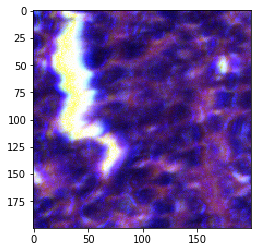

In [72]:
plt.imshow(xx[0]-xx[0].min())


In [73]:
from copy import deepcopy
xxx = deepcopy(xx)
yyy = deepcopy(yy)


In [74]:
yyy

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [75]:
STEP_SIZE_TRAIN=len(df_train)//batch_size
STEP_SIZE_VALID=len(df_val)//batch_size
mobilenet_model.fit(xxx, yyy, epochs=30, callbacks=[lrReduce], validation_data=(xxx, yyy), shuffle=False)

Train on 16 samples, validate on 16 samples
Epoch 1/30
16/16 [==============================] - 9s 543ms/step - loss: 0.7163 - val_loss: 9.0664
Epoch 2/30
16/16 [==============================] - 3s 180ms/step - loss: 7.2369 - val_loss: 9.0664
Epoch 3/30
16/16 [==============================] - 3s 179ms/step - loss: 1.6165 - val_loss: 9.0664
Epoch 4/30
16/16 [==============================] - 3s 179ms/step - loss: 1.4587 - val_loss: 9.0664
Epoch 5/30
16/16 [==============================] - 3s 200ms/step - loss: 1.0368 - val_loss: 9.0664

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.
Epoch 6/30
16/16 [==============================] - 3s 179ms/step - loss: 1.0153 - val_loss: 9.0664
Epoch 7/30
16/16 [==============================] - 3s 179ms/step - loss: 1.0124 - val_loss: 9.0664
Epoch 8/30
16/16 [==============================] - 3s 179ms/step - loss: 1.0113 - val_loss: 9.0664
Epoch 9/30
16/16 [==============================] - 3s 183ms/step - loss: 1.

KeyboardInterrupt: 

In [ ]:
STEP_SIZE_TEST=len(df_test)//batch_size
# mobilenet_model.evaluate_generator(train_generator, steps=1)
mobilenet_model.evaluate(xx, yy)

In [ ]:
for xx, yy in train_generator:
    break

In [45]:
yy

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [46]:
y_train = df_train.iloc[:, 1]
y_train.shape

(16,)

In [76]:
# y_pred = mobilenet_model.predict_generator(train_generator, steps=1)
y_pred = mobilenet_model.predict(xx)
y_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [77]:
y_pred.argmax(axis=1), y_train.values[:, 1].astype(int)

IndexError: too many indices for array

In [ ]:
y_test = df_test['label'][:len(y_pred)].values

In [ ]:
plot_roc_curve(y_test, y_pred)
plt.show()

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

In [ ]:
test_generator

In [ ]:
y_pred.sum()

In [ ]:

y_test.sum()

In [ ]:
(y_pred==y_test).sum()/220

############